# Example: Lorenz63 Equations

Problem Description
-------------------
As a first tutorial we will use the famous equations Lorenz equations.
The governing ODEs are:

$$
   \dot{x_1}(t) = \sigma (x_2(t) - x_1(t)), \\
   \dot{x_2}(t) = R x_1(t) - x_2(t) -x_1(t)x_3(t), \\
   \dot{x_3}(t) = x_1(t)x_2(t) - b x_3(t), 
$$
where $\sigma, R, b$ are physical parameters,  the dot denotes the differentiation with respect to the time $t$, respectively.

Inputing the Lorenz Model
--------------------------

To use `cnspy` generate the cns code, you need to tell `cnspy` what the functions will be calculate.

Firstly, we importing all necessary packages:

In [ ]:
import sympy as sp
import time
from cnspy import cns
from cnspy import method
from cnspy import adaptive, adaptive_parameters
import mpmath
mpmath.mp.dps =500

Then, we create the Lorenz equations through `Sympy`:

In [ ]:
t = sp.symbols(r't')
sigma,R,B = sp.symbols(r'\sigma, R, B')
u=sp.symarray('x', 3)
f1=sigma*(u[1]-u[0])
f2=R*u[0]-u[1]-u[0]*u[2]
f3=u[0]*u[1]-B*u[2]
fun=[f1,f2,f3]

Generate CNS C code of Lorenz equations
----------------------------------------

To generate the CNS code, just simply use the cns function, and the simulation is set up with several parameters and configurations as detailed below:

1. `lorenz63`: This is the variable where the simulation object is stored.
2. `cns(funcs=fun, name="lorenz63", ...)`: The `cns` function is called to initialize the simulation. The `funcs=fun` argument specifies the function(s) used for the system of equations. The name of the simulation is set to `"lorenz63"`.
3. `method=method('TS')`: The method used for solving the equations is specified as `'TS'` (likely referring to a time-stepping method or a particular solver).
4. `inits=[[u[0],"-15.8"], [u[1],"-17.48"], [u[2],"35.64"]]`: This defines the initial conditions for the system. The three initial values correspond to the state variables of the Lorenz system, presumably representing the initial values for the three variables (`u[0]`, `u[1]`, `u[2]`) at time `t=0`.
5. `paras=[[sigma,"10"], [R,"28"], [B,"8/3"]]`**: This defines the parameters of the Lorenz-63 system.
6. `tspan=(0,1000)`: The simulation will run from time `t=0` to `t=1000`.
7. `saveat=0.1`: Data will be saved at intervals of 0.1 units of time.
8. `lyap=0.91`: A parameter related to the Lyapunov exponent, which measures the rate of separation of trajectories in chaotic systems.
9. `adaptive=adaptive('t','order','wordsize',delta_T=50,remaining_T=300,gamma=1.1)`: This sets the adaptive control for the simulation, specifying:
   - `delta_T = 50`: The changing interval of the number of significant digits and order.
   - `remaining_T = 300`: The remaining time for the stabilization.
   - `gamma = 1.1`: The safety factor larger than 1.
10. `mpi=True`: This indicates that the simulation will be parallelized using MPI (Message Passing Interface), enabling the use of multiple processors.
11. `run_os='posix'`: Specifies the operating system to run the simulation, in this case, POSIX-compliant systems (e.g., Linux or macOS).
12. `printprecision=500`: The precision of the printed output is set to 500 decimal places.
13. `numofprocessor=64`: The simulation is configured to use 64 processors for parallel computation.


In [ ]:
lorenz63=cns(funcs=fun,name="lorenz63",\
           method=method('TS'),\
           inits=[[u[0],"-15.8"],[u[1],"-17.48"],[u[2],"35.64"]],\
           paras=[[sigma,"10"],[R,"28"],[B,"8/3"]],\
           tspan=(0,1000),\
           saveat=0.1,\
           lyap=0.91,\
           adaptive=adaptive('t','order','wordsize',delta_T=50,remaining_T=300,gamma=1.1),\
           mpi=True,\
           run_os= 'posix',\
           printprecision= 500,\
           numofprocessor=64)

.. note::
    The word size of the input is in binary digits, and the word size `3072` will be `924` in decimal digits. The conversion formula is: :math:`P_{dec} = P_{bin}\cdot \lg 2`. It is worth mentioning that the double accuracy is 15 decimal places ( :math:`52\cdot\lg 2=15`).

Finally, the code will be generated by calling the `generate_c_code()`:

In [ ]:
lorenz63.generate_c_code()

Run the job on a cluster
-------------------------

Then, we can run the code on a cluster with 64 processors. You can use the following code to do that:

In [ ]:
from cnspy import cluster
SL = cluster.slurm_script(node='cu10', qos='super', np=lorenz63.numofprocessor, jobname = lorenz63.name)
HN = cluster.ssh(config_path = '<path_to_your_config_file>')
lorenz63.run(HN,SL)

And ofcourse, you can run the code on your local machine:
```bash
cd lorenz63/ccode/
make
mpirun -n 4 lorenz63
```

Finally, we can read the data and generate a RK4 solution to compare:

In [ ]:
#read result
lorenz63.read_cnssol()
#rk4 result
lorenz63.quick_run()

Similarly, we can run the Lorenz96 model only adaptive in time to generate a examine CNS case with higher order and number of significant digits:

In [ ]:
lorenz63_higher=cns(funcs=fun,name="lorenz63_higher",\
           method=method('TS',order=800,nosd=500),\
           inits=[[u[0],"-15.8"],[u[1],"-17.48"],[u[2],"35.64"]],\
           paras=[[sigma,"10"],[R,"28"],[B,"8/3"]],\
           tspan=(0,1000),\
           saveat=0.1,\
           lyap=0.91,\
           adaptive=adaptive('t'),\
           mpi=True,\
           printprecision= 500,\
           numofprocessor=64)

In [ ]:
lorenz63_higher.generate_c_code()

In [ ]:
from cnspy import cluster
SL = cluster.slurm_script(node='cu5', qos='super', np=lorenz63_higher.numofprocessor, jobname = lorenz63_higher.name)
HN = cluster.ssh()
lorenz63_higher.run(HN,SL)

In [ ]:
#read result
lorenz63_higher.read_cnssol()
#rk4 result
lorenz63_higher.quick_run()

Then, to compare the adaptive in order and wordsize, we can use the following code:

In [ ]:
lorenz63_fix=cns(funcs=fun,name="lorenz63_fix",\
           method=method('TS',order=617,nosd=411),\
           inits=[[u[0],"-15.8"],[u[1],"-17.48"],[u[2],"35.64"]],\
           paras=[[sigma,"10"],[R,"28"],[B,"8/3"]],\
           tspan=(0,1000),\
           saveat=0.1,\
           lyap=0.91,\
           adaptive=adaptive('t'),\
           mpi=True,\
           printprecision= 500,\
           numofprocessor=64)

In [ ]:
lorenz63_fix.generate_c_code()

In [ ]:
from cnspy import cluster
SL = cluster.slurm_script(node='cu10', qos='super', np=lorenz63_fix.numofprocessor, jobname = lorenz63_fix.name)
HN = cluster.ssh()
lorenz63_fix.run(HN,SL)

In [ ]:
#read result
lorenz63_fix.read_cnssol()
#rk4 result
lorenz63_fix.quick_run()

Plot the results
----------------

Now, it's time to compare and plot the results.

Firstly, we define the relative error function by:
$$
\varepsilon_r(t) = \dfrac{\sum_{i=1}^{N_d}\left| x_i^{\prime}(t) - x_i(t) \right|}{\sum_{i=1}^{N_d}\left| x_i^{\prime}(t) \right|},
$$
where $N_d$ is the number of the variable~(i.e. dimensions of the model), $x_i^{'}(t)$ and $x_i(t)$ are two CNS results with different level of the background numerical noise, respectively.

The code can be defined by:

In [ ]:
import sympy as sp
def relative_error(y1, y2):
    for j in range(len(y1[:,0])):
        if j == 0:
            era = [sp.Float(abs(y1[j,i] - y2[j,i])) for i in range(len(y1[0,:]))]
            erb = [sp.Float(abs(y2[j,i])) for i in range(len(y1[0,:]))]
        else:
            era = [ era[i] + sp.Float(abs(y1[j,i] - y2[j,i])) for i in range(len(y1[0,:]))]
            erb = [ erb[i] + sp.Float(abs(y2[j,i])) for i in range(len(y1[0,:]))]
    return [era[i] / erb[i] for i in range(len(era))]

Then, we can plot the relative error of the three method via the examine case:

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
Failed to find a Ghostscript installation.  Distillation step skipped.


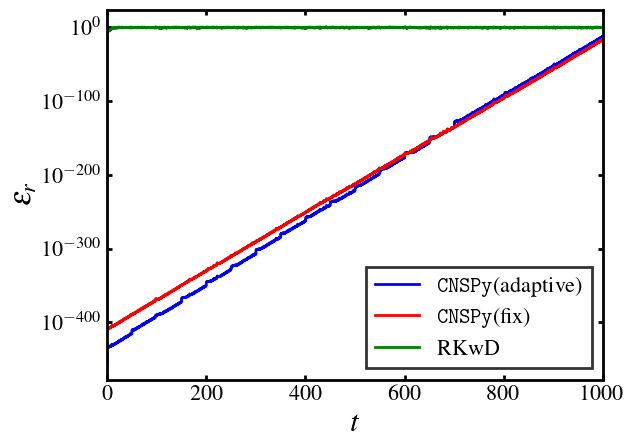

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc("legend",fancybox=False)
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath} \boldmath')
rc('patch',linewidth=2)
font = {'family' : 'serif',
        'serif':['Times'],
        'weight' : 'bold',
        'size'   : 16}
rc('font', **font)
from matplotlib.ticker import FuncFormatter

x = lorenz63.cnssol.t
y1 = relative_error(lorenz63.cnssol.y, lorenz63_higher.cnssol.y)
y2 = relative_error(lorenz63_fix.cnssol.y, lorenz63_higher.cnssol.y)
y3 = relative_error(lorenz63.qrsol.y, lorenz63_higher.cnssol.y)
def log_formatter(x, pos):
    return "$10^{{{:d}}}$".format(int(x))

formatter = FuncFormatter(log_formatter)

fig, ax = plt.subplots()

y11 = list(map(lambda x:sp.log(x, 10), y1))
y22 = list(map(lambda x:sp.log(x, 10), y2))
y33 = list(map(lambda x:sp.log(x, 10), y3))
ax.plot(x, y11,label=r'\texttt{CNSPy}(adaptive)',linestyle="-",linewidth=2,color="blue")
ax.plot(x, y22,label=r'\texttt{CNSPy}(fix)',linestyle="-",linewidth=2,color="red")
ax.plot(x, y33,label=r'RKwD',linestyle="-",linewidth=2,color="green")
ax.yaxis.set_major_formatter(formatter)
ax.set_xlim(0,1000)
ax.set_xlabel(r'$\boldsymbol{t}$', fontsize=22, fontweight='bold')
ax.set_ylabel(r'$\boldsymbol{\epsilon_r}$', fontsize=22, fontweight='bold')
ax.tick_params(direction="in",top=True,right=True,width=2)
ax.legend(edgecolor="inherit",loc="best")
for location in  ["left", "right", "top", "bottom"]:
    ax.spines[location].set_linewidth(2)

fig.savefig("lorenz63_error.eps",bbox_inches='tight')


We can also check the last 20 unit time of the simulation:

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
Failed to find a Ghostscript installation.  Distillation step skipped.


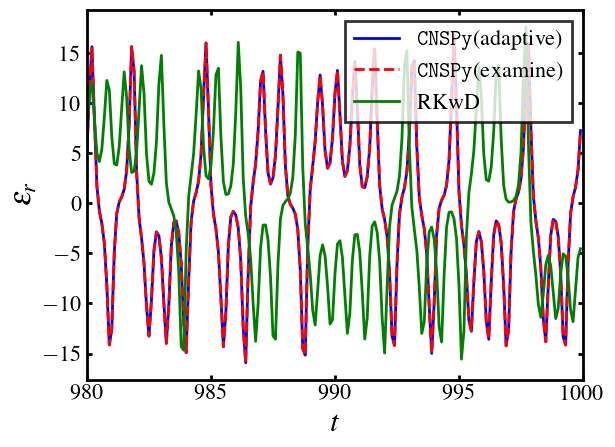

In [ ]:
#plot phase space
import matplotlib.pyplot as plt
from matplotlib import rc
rc("legend",fancybox=False)
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath} \boldmath')
rc('patch',linewidth=2)
font = {'family' : 'serif',
        'serif':['Times'],
        'weight' : 'bold',
        'size'   : 16}
rc('font', **font)
fig, ax = plt.subplots()
ax.plot(lorenz63.cnssol.t[9800:10000],lorenz63.cnssol.y[0,9800:10000],label=r'\texttt{CNSPy}(adaptive)',linestyle="-",linewidth=2,color="blue")
ax.plot(lorenz63_higher.cnssol.t[9800:10000],lorenz63_higher.cnssol.y[0,9800:10000],label=r'\texttt{CNSPy}(examine)',linestyle="--",linewidth=2,color="red")
ax.plot(lorenz63.qrsol.t[9800:10000],lorenz63.qrsol.y[0,9800:10000],label=r'RKwD',linestyle="-",linewidth=2,color="green")

ax.set_xlim(980,1000)
ax.set_xlabel(r'$\boldsymbol{t}$', fontsize=22, fontweight='bold')
ax.set_ylabel(r'$\boldsymbol{\epsilon_r}$', fontsize=22, fontweight='bold')
ax.tick_params(direction="in",top=True,right=True,width=2)
ax.legend(edgecolor="inherit",loc="best")
for location in  ["left", "right", "top", "bottom"]:
    ax.spines[location].set_linewidth(2)

fig.savefig("lorenz63_x1.eps",bbox_inches='tight')

Or check the adaptive process of the order and error in the whole calculated time:
    

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
Failed to find a Ghostscript installation.  Distillation step skipped.


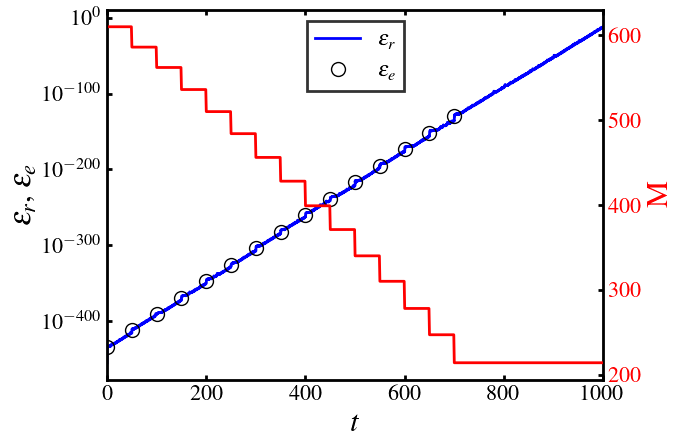

In [ ]:
import numpy as np
import mpmath
def order_nosd_time(system):
    magic_number = system.adptv_para.magic_number
    gamma = system.adptv_para.gamma
    remaining_T = system.adptv_para.remaining_T
    lyap = system.lyap 
    tmax = system.tspan[1]
    time = [i for i in range(0, tmax+1)]
    delta_T = system.adptv_para.delta_T
    order = np.zeros(len(time))
    nosd = np.zeros(len(time))
    desire_error = []
    desire_time = []
    for i in range(0, len(time)):
        if i % delta_T == 0 and i <= tmax - remaining_T:
            nosd[i] = int(gamma*lyap*(tmax-i)/np.log(10.0))
            desire_error.append(10**(-mpmath.mp.mpf(nosd[i])))
            desire_time.append(i)
        else:
            nosd[i] = nosd[i-1]
        order[i] = int(magic_number[0]*nosd[i]*nosd[i]+magic_number[1]*nosd[i]+magic_number[2])
        order[-1] = order[-2]
        nosd[-1] = nosd[-2]
        
    return time, np.array(desire_time), order, nosd, np.array(desire_error)

import matplotlib.pyplot as plt
from matplotlib import rc
rc("legend",fancybox=False)
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath} \boldmath')
rc('patch',linewidth=2)
font = {'family' : 'serif',
        'serif':['Times'],
        'weight' : 'bold',
        'size'   : 16}
rc('font', **font)
from matplotlib.ticker import FuncFormatter

x = lorenz63.cnssol.t
y1 = relative_error(lorenz63.cnssol.y, lorenz63_higher.cnssol.y)
t_lorenz63, desire_time_lorenz63, order_lorenz63, nosd_lorenz63, desire_error_lorenz63 = order_nosd_time(lorenz63)
def log_formatter(x, pos):
    return "$10^{{{:d}}}$".format(int(x))

formatter = FuncFormatter(log_formatter)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
y11 = list(map(lambda x:sp.log(x, 10), y1))
y22 = list(map(lambda desire_time_lorenz63:sp.log(desire_time_lorenz63, 10), desire_error_lorenz63))
ax1.plot(x, y11,label=r'$\boldsymbol{\epsilon_{r}}$',linestyle="-",linewidth=2,color='blue')
ax1.plot(desire_time_lorenz63, y22,label=r'$\boldsymbol{\epsilon_{e}}$',marker="o", markersize=10,color='none', markerfacecolor='none', markeredgecolor="black")
ax2.plot(x[::10], order_lorenz63,label='order',linestyle="-",linewidth=2,color='red')
ax2.tick_params(direction="in",axis='y', labelcolor='red',width=2)
ax2.set_ylabel(r'M', fontsize=22, color='red', fontweight='bold')
ax1.yaxis.set_major_formatter(formatter)
ax1.set_xlim(0,1000)
ax1.set_xlabel(r'$\boldsymbol{t}$', fontsize=22, fontweight='bold')
ax1.set_ylabel(r'$\boldsymbol{\epsilon_r}$, $\boldsymbol{\epsilon_e}$', fontsize=22, fontweight='bold')
ax1.tick_params(direction="in",top=True,width=2)
ax1.legend(edgecolor="inherit",loc="upper center")
for location in  ["left", "right", "top", "bottom"]:
    ax1.spines[location].set_linewidth(2)

fig.savefig("algorithm_lorenz63.eps",bbox_inches='tight')